## Importowanie wszystkich zależności

In [97]:
import sys
sys.path.append('../')

In [98]:
import DataUtils as du
import numpy as np
from SectionUtils import *
from Augmentation import Augmentation
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

## Tworzenie zbioru danych dwu wymiarowych x_train oraz y_train za pomocą funkcji make_blobs z sklearn.datasets.
#### Jest w tym zbiorze danych 500 punktów otoczonych wokół jednego centrum, które zostały stworzone w oparciu o jedno odchylenie standardowe

In [99]:
x_train, y_train = make_blobs(n_samples=500, centers=1, random_state=42, cluster_std=1.0)

### skalowanie danych Standardowym skalowaniem z biblioteki sklearn.preprocesing
### aplikowanie metody LOF
### przesunięcie danych do środka masy

In [100]:
x_train = du.DataUtils.normalize_data(x_train)
x_train = du.DataUtils.remove_outliers_lof(x_train)
shift_vector = du.DataUtils.mass_center(x_train)
x_train = du.DataUtils.shift_by_vector(x_train, shift_vector)
no_generate = x_train.copy()
x_train = du.DataUtils.listed_class(x_train)

### Wykres punktow wygenerowanych

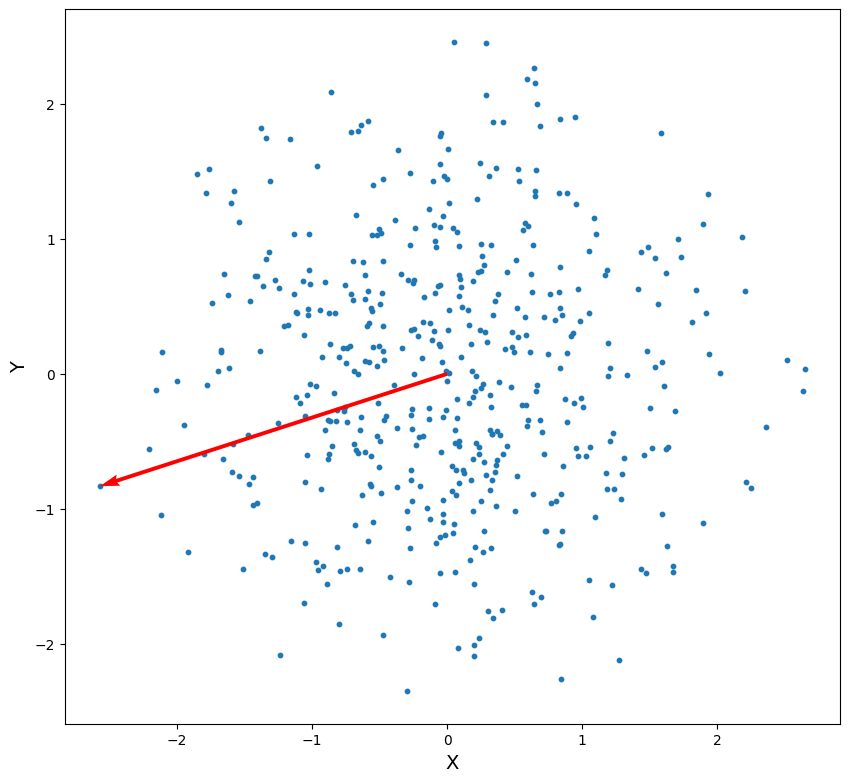

In [101]:
before_shift = x_train.copy()

max_r = du.DataUtils.max_radious_object(before_shift)

before_shift = np.array([before_shift[i].getXY() for i in range(len(before_shift))])

plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
plt.scatter(before_shift[:, 0], before_shift[:, 1], s=10)
plt.quiver([0], [0], [max_r.getXY()[0]], [max_r.getXY()[1]], angles='xy', scale_units='xy', scale=1, color='red', width=0.005)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

## Poczatek Augmentacji.
### Tworzenie tablicy z elementami klasy Coordinate

## Podzial punktow na sekcje


### Liczba sekcji

In [102]:
section_count = 7

### Przesuwanie punktow o kat $\alpha$ aby potem latwiej manipulować danymi

In [103]:
phiShiftByMaxRadious = du.DataUtils.getPhiShiftByMaxRadious(x_train, section_count)
du.DataUtils.addShiftPhi(x_train, -phiShiftByMaxRadious)

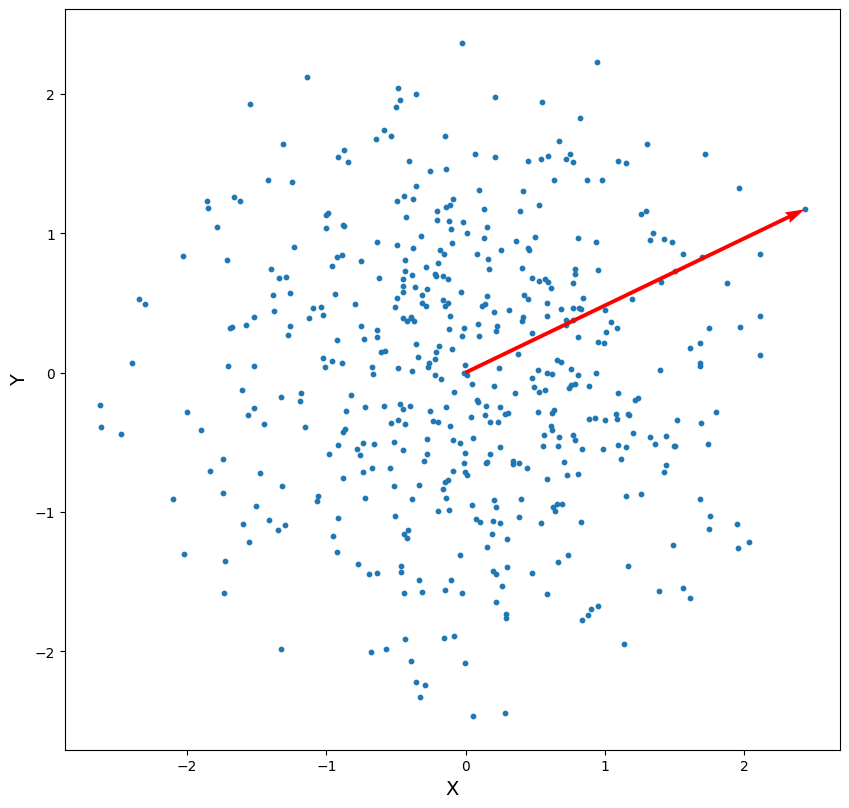

In [104]:
shifted = x_train.copy()
shifted = np.array([shifted[i].getXY() for i in range(len(shifted))])
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal')
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.scatter(shifted[:, 0], shifted[:, 1], s=10)
plt.quiver([0], [0], [max_r.getXY()[0]], [max_r.getXY()[1]], angles='xy', scale_units='xy', scale=1, color='red', width=0.005)
plt.show()

### Zainicjalizowanie punktow

In [105]:
sectionGroup = SectionGroup(x_train, section_count)

### Wlasciwy podzial na sekcje

In [106]:
sections = [Section(sectionGroup, i) for i in range(section_count)]

In [107]:
max_subsec = 0

for section in sections:
    max_subsec = section.subsec_num_phi * section.subsec_num_r * sectionGroup.section_count    

    subsections = [SubSection(section, i, j) for i in range(section.subsec_num_phi) for j in range(section.subsec_num_r)]

    r_color_section = random.uniform(0,1)
    g_color_section = random.uniform(0,1)
    b_color_section = random.uniform(0,1)

    for subsection in subsections:
    
        points = subsection.points
        
        r_color_subsection = random.uniform(0,1)
        g_color_subsection = random.uniform(0,1)
        b_color_subsection = random.uniform(0,1)

        for point in points:

            point.setSectionID(section.section_index)
            point.setSubsectionID(subsection.subsection_index)
            point.setGlobalSubsectionID(point.getSectionID() * section.subsec_num_phi * section.subsec_num_r + point.getSubsectionID())
            point.setColorSection((r_color_section, g_color_section, g_color_section))
            point.setColorSubSection((r_color_subsection,g_color_subsection,b_color_subsection))


### Wykres punktow z podzialem na sekcje

#### Wykres punktow x, y

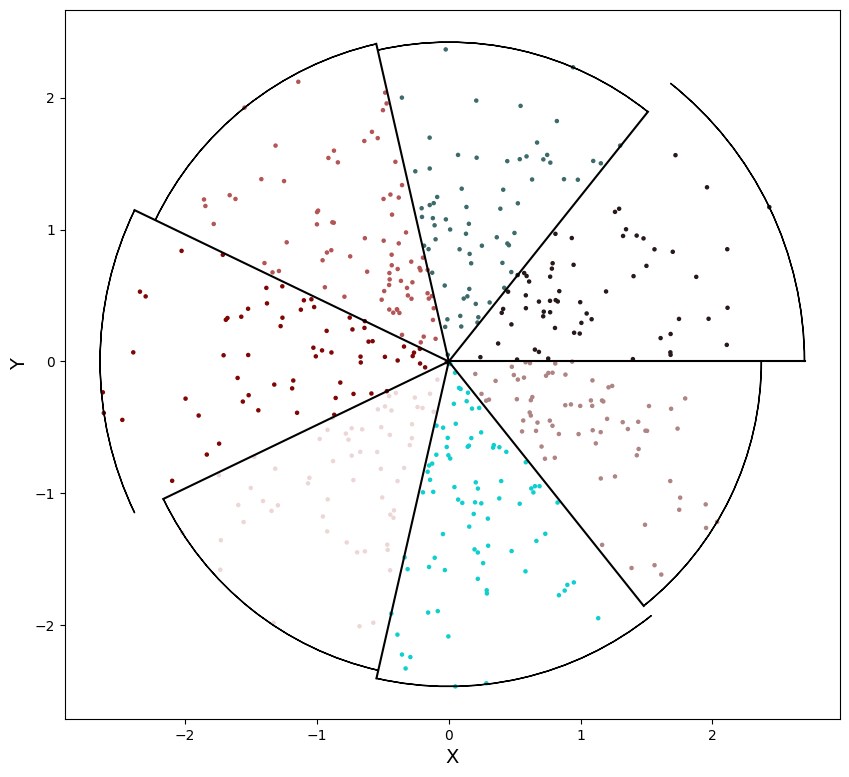

In [108]:
plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
for section in sections:
    sect_points = section.points

    sect_color_points = [sect_points[i].getColorSection() for i in range(len(sect_points))]   
    sect_points = np.array([sect_points[i].getXY() for i in range(len(sect_points))])

    plt.scatter(sect_points[:, 0], sect_points[:, 1], color=sect_color_points, s=5)
    sec_x = np.cos(section.phi_size * (section.section_index)) * section.max_r
    sec_y = np.sin(section.phi_size * (section.section_index)) * section.max_r

    plt.plot([0, sec_x], [0, sec_y], color='black')

    wycinek_center = Wedge(center=(0, 0), r=section.max_r, 
                        theta1=np.degrees(section.phi_size * section.section_index), 
                        theta2=np.degrees(section.phi_size * (section.section_index + 1)), width=0.001, color='black')
    
    plt.gca().add_patch(wycinek_center)

plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

#### Wykres punktow biegunowych

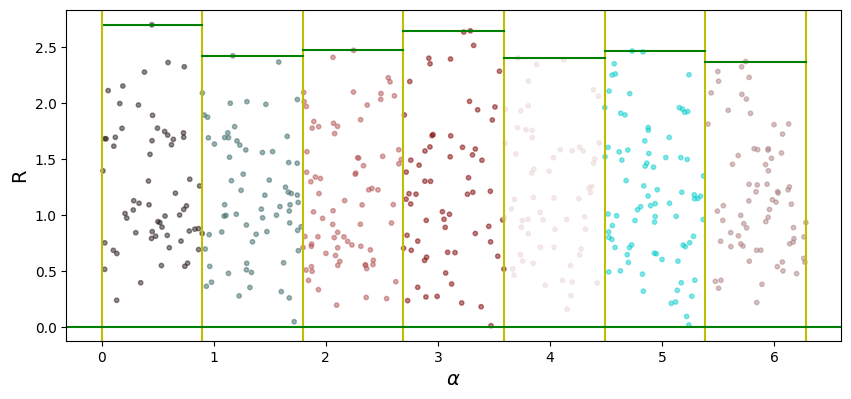

In [109]:
plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
for section in sections:
    polar_sect_points = section.points
    polar_sect_color_points = [point.getColorSection() for point in polar_sect_points] 
    polar_sect_points = [[point.getPhi(), point.getR()] for point in polar_sect_points]
    polar_sect_points = np.array(polar_sect_points)
    plt.scatter(polar_sect_points[: , 0], polar_sect_points[: , 1], color=polar_sect_color_points, alpha=0.5, s=10)
    plt.axvline(x=section.phi_size*(section.section_index+1), color='y')
    x_range = np.linspace(section.phi_size*section.section_index, section.phi_size*(section.section_index+1))
    y_value = np.ones_like(x_range) * section.max_r
    
    plt.plot(x_range, y_value, color='g')

plt.axvline(x=0, color='y')
plt.axhline(y=0, color='g')
plt.xlabel(r'$\alpha$',fontsize=14)
plt.ylabel('R',fontsize=14)
plt.show()

### Podzial na podsekcje

In [110]:
for section in sections:
    subsections = [SubSection(section, i, j) for i in range(section.subsec_num_phi) for j in range(section.subsec_num_r)]

In [111]:
for subsection in subsections:
    subsection_points = subsection.points
    for point in subsection_points:
        co.Coordinate.setSubsectionID

### Wykres punktow z podzialem na podsekcje
#### Wykres punktow x,y

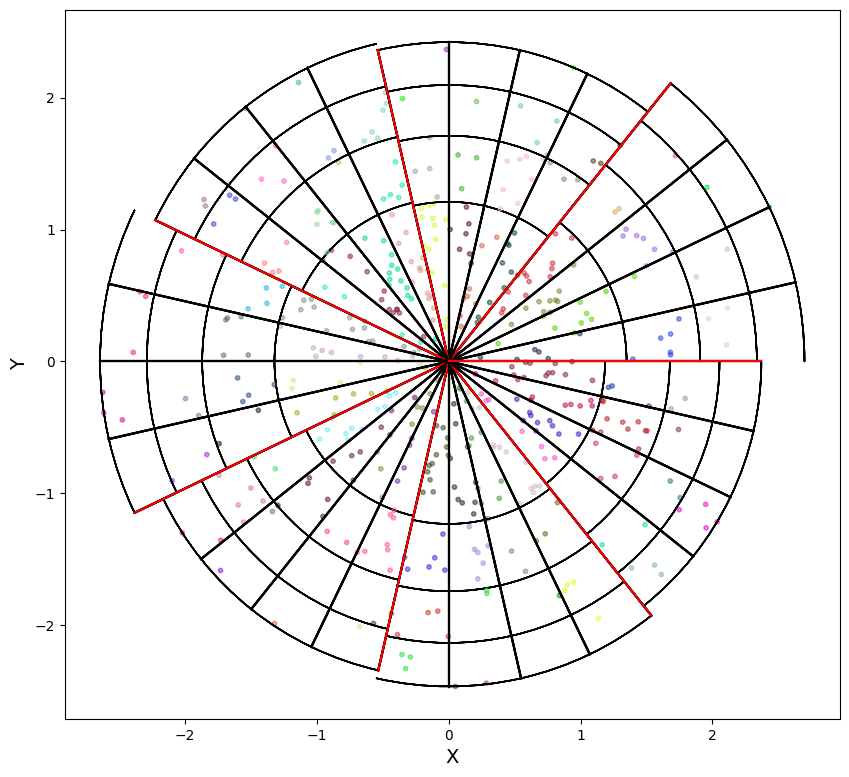

In [112]:
plt.figure(figsize=(10, 10))

for section in sections:
    subsections = [SubSection(section, i, j) for i in range(section.subsec_num_phi) for j in range(section.subsec_num_r)]
    for subsection in subsections:
        subsect_points = subsection.points
        subsect_color_points = [point.getColorSubSection() for point in subsect_points]

        subsect_points = [point.getXY() for point in subsect_points]
        subsect_points = np.array(subsect_points)
        if len(subsect_points) > 0:
            plt.scatter(subsect_points[:, 0], subsect_points[:, 1], color=subsect_color_points, alpha=0.5, s=10)

        wycinek_center = Wedge(center=(0, 0), r=subsection.r_range[1], 
                               theta1=np.degrees(section.phi_size * section.section_index), 
                               theta2=np.degrees(section.phi_size * (section.section_index + 1)), width=0.001, color='black')
        
        plt.gca().add_patch(wycinek_center)
        
        x = np.cos(subsection.phi_range[1]) * section.max_r
        y = np.sin(subsection.phi_range[1]) * section.max_r
        plt.plot([0, x], [0, y], color='black')
    
    sec_x = np.cos(section.phi_size * (section.section_index + 1)) * section.max_r
    sec_y = np.sin(section.phi_size * (section.section_index + 1)) * section.max_r
    plt.plot([0, sec_x], [0, sec_y], color='red')
    


plt.gca().set_aspect('equal')
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

#### Wykres punktow biegunowych

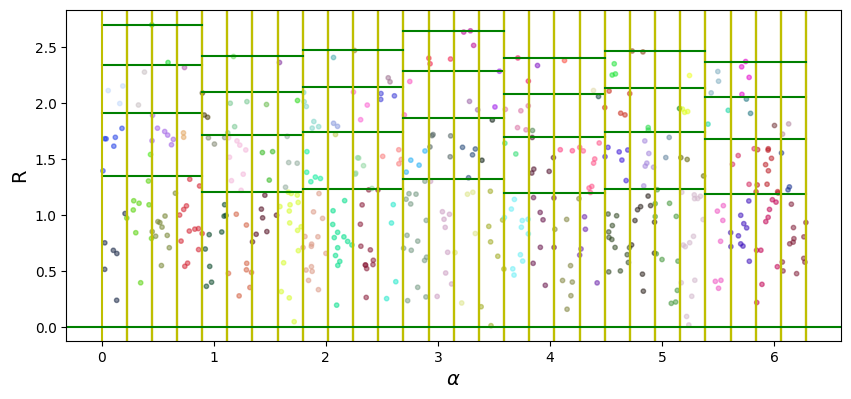

In [113]:
plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
for section in sections:
    
    subsections = [SubSection(section, i, j) for i in range(section.subsec_num_phi) for j in range(section.subsec_num_r)]
    for subsection in subsections:
        polar_subsect_points = subsection.points
        polar_subsect_color_points = [point.getColorSubSection() for point in polar_subsect_points] 
        polar_subsect_points = [[point.getPhi(), point.getR()] for point in polar_subsect_points]
        polar_subsect_points = np.array(polar_subsect_points)
        if len(polar_subsect_points) > 0:
            plt.scatter(polar_subsect_points[:, 0], polar_subsect_points[:, 1], color=polar_subsect_color_points, alpha=0.5, s=10)
        plt.axvline(x=subsection.phi_range[1], color='y')
        x_range = np.linspace(subsection.phi_range[0], subsection.phi_range[1])
        y_value = np.ones_like(x_range) * subsection.r_range[1]


        
        plt.plot(x_range, y_value, color='g')

plt.axvline(x=0, color='y')
plt.axhline(y=0, color='g')
plt.xlabel(r'$\alpha$',fontsize=14)
plt.ylabel('R',fontsize=14)
plt.show()

### Dolosowywanie punktow w oparciu o przedzialy R oraz $\alpha$

In [114]:
Augmentation(points=x_train, section_count=section_count, global_points_gen=1000)

### Wykresy po Augmentacji

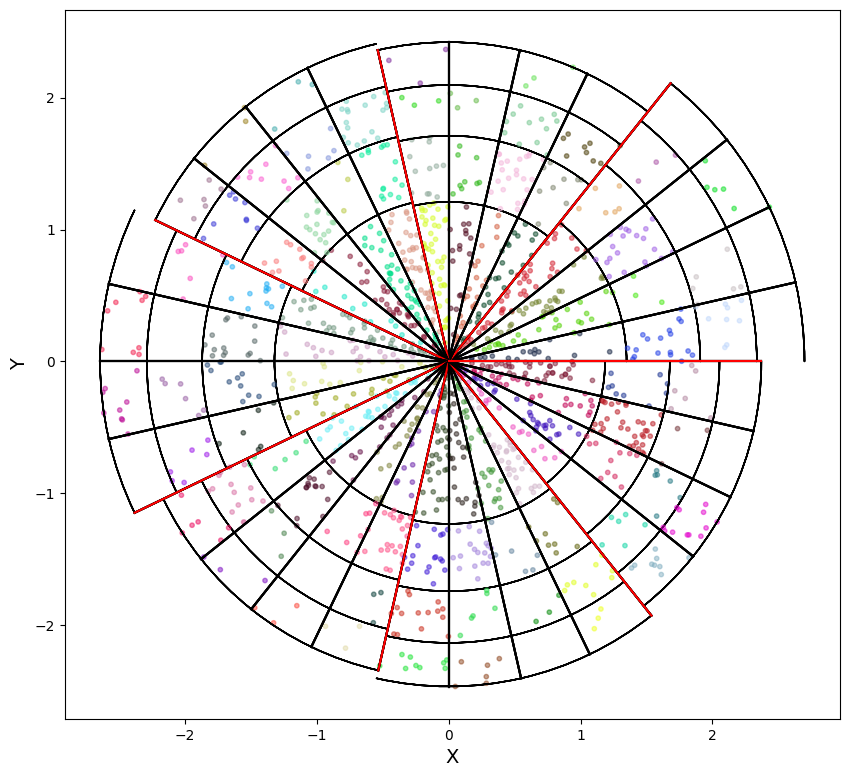

In [115]:
sectionGroup = SectionGroup(x_train, section_count)
sections = [Section(sectionGroup, i) for i in range(section_count)]
plt.figure(figsize=(10, 10))

for section in sections:
    subsections = [SubSection(section, i, j) for i in range(section.subsec_num_phi) for j in range(section.subsec_num_r)]
    for subsection in subsections:
        subsect_points = subsection.points
        subsect_color_points = [point.getColorSubSection() for point in subsect_points] 
        subsect_points = [point.getXY() for point in subsect_points]
        subsect_points = np.array(subsect_points)
        if len(subsect_points) > 0:
            plt.scatter(subsect_points[:, 0], subsect_points[:, 1], color=subsect_color_points, alpha=0.5, s=10)

        wycinek_center = Wedge(center=(0, 0), r=subsection.r_range[1], 
                               theta1=np.degrees(section.phi_size * section.section_index), 
                               theta2=np.degrees(section.phi_size * (section.section_index + 1)), width=0.001, color='black')
        
        plt.gca().add_patch(wycinek_center)

        
        x = np.cos(subsection.phi_range[1]) * section.max_r
        y = np.sin(subsection.phi_range[1]) * section.max_r
        plt.plot([0, x], [0, y], color='black')
    
    sec_x = np.cos(section.phi_size * (section.section_index + 1)) * section.max_r
    sec_y = np.sin(section.phi_size * (section.section_index + 1)) * section.max_r
    plt.plot([0, sec_x], [0, sec_y], color='red')
    


plt.gca().set_aspect('equal')
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

### Wykres zalezny od R i $\alpha$

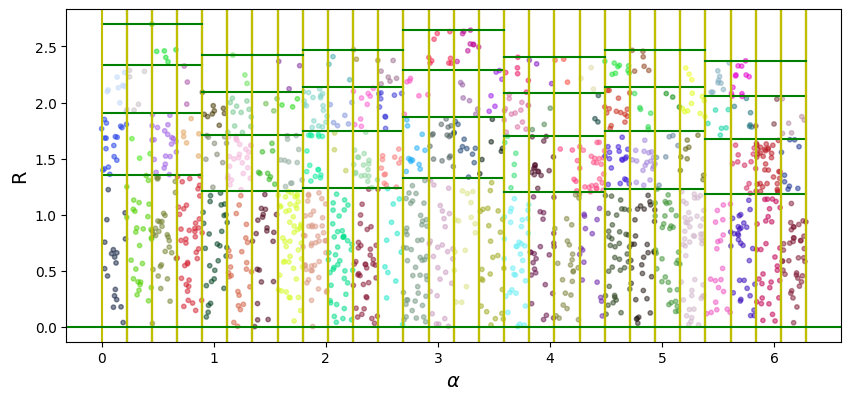

In [116]:
plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
color_index = 0
for section in sections:
    
    subsections = [SubSection(section, i, j) for i in range(section.subsec_num_phi) for j in range(section.subsec_num_r)]
    for subsection in subsections:
        polar_subsect_points = subsection.points
        polar_subsect_color_points = [point.getColorSubSection() for point in polar_subsect_points] 
        polar_subsect_points = [[point.getPhi(), point.getR()] for point in polar_subsect_points]
        polar_subsect_points = np.array(polar_subsect_points)
        if len(polar_subsect_points) > 0:
            plt.scatter(polar_subsect_points[:, 0], polar_subsect_points[:, 1], color=polar_subsect_color_points, alpha=0.5, s=10)
        plt.axvline(x=subsection.phi_range[1], color='y')
        x_range = np.linspace(subsection.phi_range[0], subsection.phi_range[1])
        y_value = np.ones_like(x_range) * subsection.r_range[1]

        color_index += 1
        
        plt.plot(x_range, y_value, color='g')

plt.axvline(x=0, color='y')
plt.axhline(y=0, color='g')
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('R',fontsize=14)
plt.show()

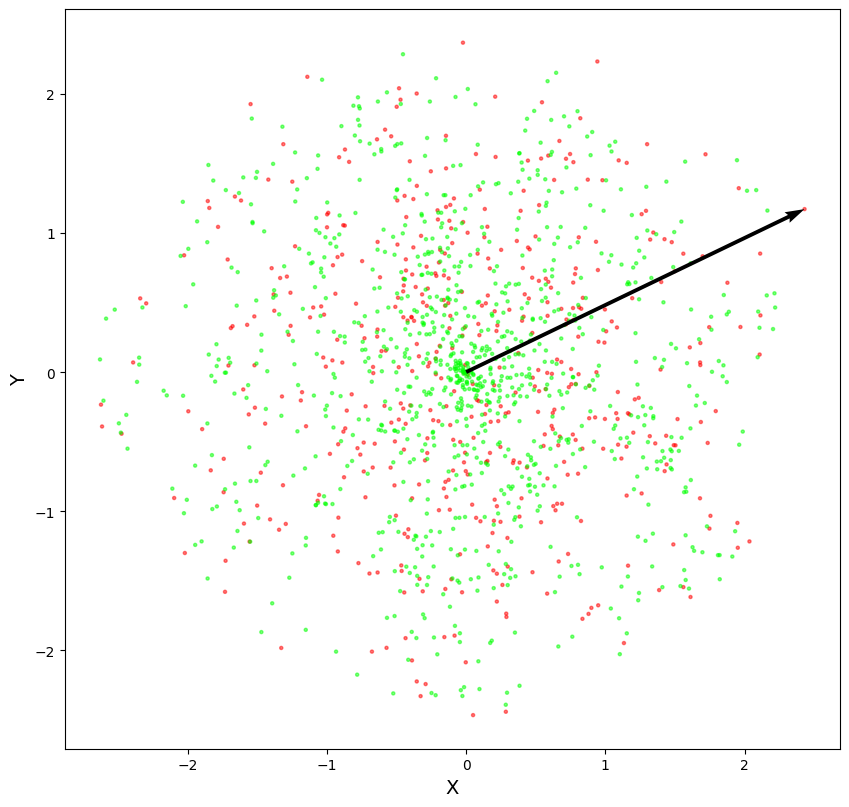

In [117]:
custom_color_points = [point.getCustomColor() for point in x_train]
after_generate = [point.getXY() for point in x_train]
after_generate = np.array(after_generate)
plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
plt.scatter(after_generate[:, 0], after_generate[:, 1], color=custom_color_points, alpha=0.5, s=5)
plt.quiver([0], [0], [max_r.getXY()[0]], [max_r.getXY()[1]], angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

### Obracamy wszystkie punkty o shiftPhi

In [118]:
du.DataUtils.addShiftPhi(x_train, phiShiftByMaxRadious)

### Wykres po obrocie

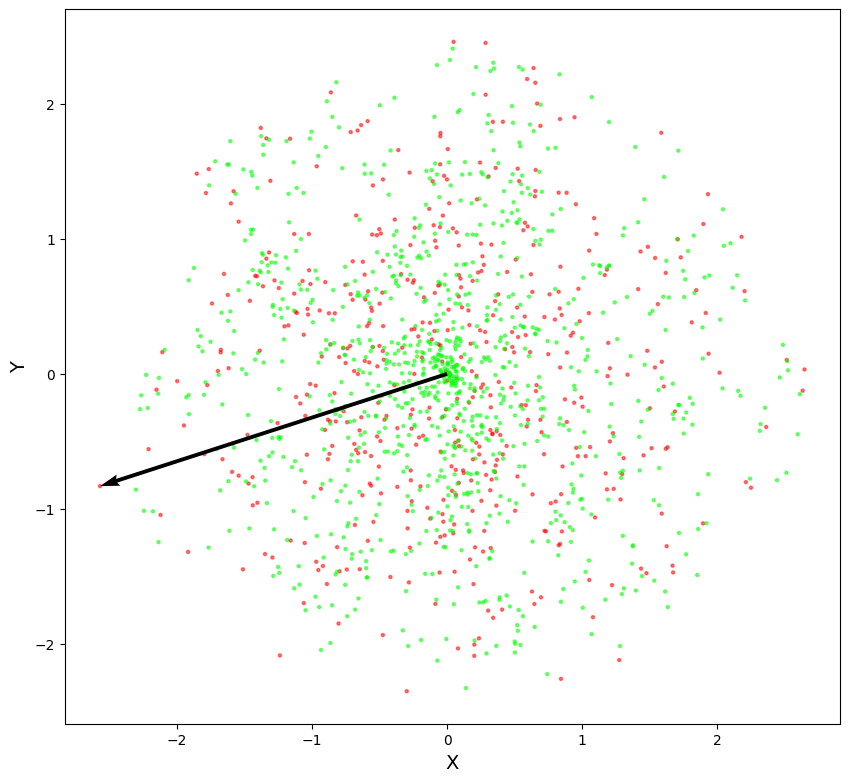

In [119]:
custom_color_points = [point.getCustomColor() for point in x_train]
after_generate = [point.getXY() for point in x_train]
after_generate = np.array(after_generate)
plt.figure(figsize=(10, 10))
plt.gca()
plt.gca().set_aspect('equal')
plt.scatter(after_generate[:, 0], after_generate[:, 1], color=custom_color_points, alpha=0.5, s=5)
plt.quiver([0], [0], [max_r.getXY()[0]], [max_r.getXY()[1]], angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.show()

## Zakonczenie generowania dodatkowych danych

In [120]:
len(x_train)

1474